### импорт библиотек и вспомогательные функции

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Введение и импорт данных

когортный анализ  применяется, когда  нужно  сравнить поведение во времени между собой двух или более групп. В зависимости от поставленной задачи в когортном анализе важно четко зафиксировать ответы на следующие вопросы:

1) по какому признаку выделяем когорты?  
2) по какому показателю сравниваем когорты между собой?      

Посмотрим на конкретные примеры когортного анализа

In [0]:
#data = pd.read_csv('Online_Retail.csv')
#data['timestamp'] = pd.to_datetime(data['InvoiceDate'])

In [3]:
from google.colab import files
uploaded=files.upload()


Saving Online_Retail.csv to Online_Retail.csv


In [0]:
import io
data = pd.read_csv(io.StringIO(uploaded['Online_Retail.csv'].decode('utf-8')),sep=',')

In [6]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,client_id,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [0]:
data['timestamp'] = pd.to_datetime(data['InvoiceDate'])

In [8]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,client_id,Country,timestamp
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00


In [9]:
data['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [0]:
def visualize_all_data(df):
    data = df.copy()
    min_date = data['timestamp'].min()
    max_date = data['timestamp'].max()

    data['delta'] = (data['timestamp'] - min_date).apply(lambda x: np.floor(x.days/7))


    g_data = data.groupby('client_id').first().reset_index()
    g_data['delta'] = (g_data['timestamp'] - min_date).apply(lambda x: np.floor(x.days/7))

    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})
    bin_num=int(np.floor((max_date-min_date).days/7))
    
    sns.distplot(data['delta'], kde=False,bins=bin_num, norm_hist=True, label='')
    sns.distplot(g_data['delta'], kde=False,bins=bin_num, norm_hist=True, label='')
    plt.xlabel('Недели с начала наблюдения')

    plt.legend(labels=["Все покупки в эту неделю","Пользователи, пришедшие в эту неделю"])
    plt.show()
    print('начало наблюдения: '+ str(min_date))

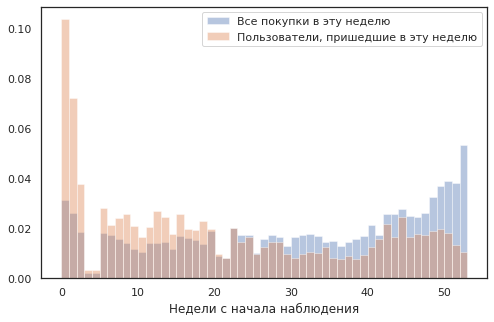

начало наблюдения: 2010-12-01 08:26:00


In [34]:
visualize_all_data(data)

мы видим, что данные собирались в период примерно 1 год. Т.е. для разных пользователей история наблюдения сильно варьируется. 

Как в этом случае делать аналитику, если мы, например, хотим измерить retention и  как он меняется со временем? 

Ответ - для этого используется когортный анализ. 

Пользователи разбираются на группы по определенным признакам и группы анализируются между собой. 

В простейшем варианте это может быть разбиение по времени присоединения. 

Пользователи присоединившиеся за первые неделю с начала наблюдения - это одна когорта

пользователи присоединившиеся тоже за недельный интервал, но спустя 60 дней - это будет другая когорта

Поведение пользователей можно пронаблюдать продолжительное время и сделать вывод о том, каким retention обладает каждая их когорт. На основе этого можно например сделать анализ - изменился ли у нас retention за 60 дней или нет

В данном случае наш анализ можно резюмировать:

1) по какому признаку выделяем когорты? - `acquisution time`  
2) по какому показателю сравниваем когорты между собой?  - `retention`

## 1. Выделение когорт по времени присоединения

In [0]:
#размер когорты (в этом примере этот параметр будет также использоваться как величина периода для наблюдений за когортой)
cohort_size = 14
#интервал времени между когортами для сравнения
interval_between_cohorts = 60

#найдем для пользоваателей их даты присоединения:
g_data = data.groupby('client_id')['timestamp'].first().reset_index()
#колонка delta - день присоединения с начала наблюдения:
g_data['delta'] = (g_data['timestamp'] - data['timestamp'].min()).apply(lambda x: x.days)


#получим айдишники  пользователей присоединившихся в первую неделю и во вторую:
cohort_1_users = g_data[g_data['delta']<=cohort_size]['client_id'].unique()
cohort_2_users = g_data.loc[(g_data['delta']>interval_between_cohorts) &
                            (g_data['delta']<=interval_between_cohorts+cohort_size)]['client_id'].unique()

#полные логи событий для каждой из когорт:
data_c1 = data[data['client_id'].isin(cohort_1_users)].copy()
data_c2 = data[data['client_id'].isin(cohort_2_users)].copy()

Визуализируем теперь аналогично время регистрации новых событий/ новых пользователей для выделенных когорт:

In [0]:
def visualize_users(df):
    data = df.copy()
    min_date = data['timestamp'].min()

    g_data = data.groupby('client_id').first().reset_index()
    g_data['delta'] = (g_data['timestamp'] - min_date).apply(lambda x: x.days/7)

    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})

    sns.distplot(g_data['delta'], kde=False,bins=2, norm_hist=False, label='')
    plt.xlabel('Недели с начала наблюдения когортой')

    plt.legend(labels=["Пользователи, пришедшие в эту неделю"])
    plt.xlim([0,53])
    plt.show()
    print('начало наблюдения за когортой: '+ str(min_date))

def visualize_purchases(df):
    data = df.copy()
    min_date = data['timestamp'].min()
    max_date = data['timestamp'].max()

    data['delta'] = (data['timestamp'] - min_date).apply(lambda x: np.floor(x.days/7))


    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})
    bin_num=int(np.floor((max_date-min_date).days/7))
    
    sns.distplot(data['delta'], kde=False,bins=bin_num, norm_hist=False, label='')
    plt.xlabel('Недели с начала наблюдения за когортой')

    plt.legend(labels=["Все покупки в эту неделю"])
    plt.xlim([0,53])
    plt.show()
    print('начало наблюдения за когортой: '+ str(min_date))

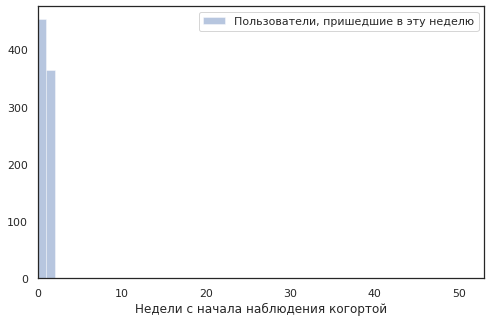

начало наблюдения за когортой: 2010-12-01 08:26:00


In [49]:
 visualize_users(data_c1)

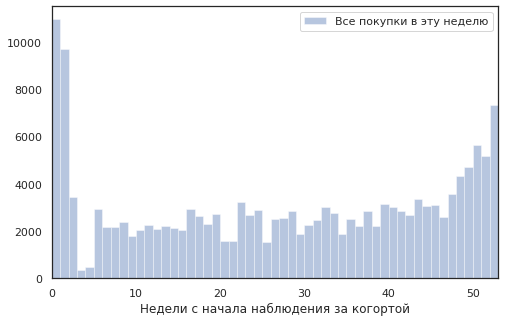

начало наблюдения за когортой: 2010-12-01 08:26:00


In [50]:
visualize_purchases(data_c1)

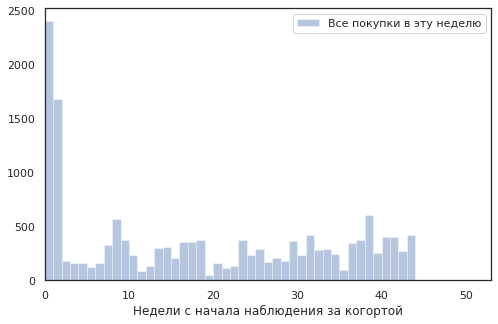

начало наблюдения за когортой: 2011-01-31 09:05:00


In [51]:
visualize_purchases(data_c2)

Мы видим, что теперь каждая из когорт содержит данных поведения пользователей пришедных в определенный интервал времени (первая и вторая неделя с начала наблюдения, соответсвенно) для которых мы отслеживали все дальнейшее поведеение в  течение года

Можем сравнить поведение когорт между собой.  

Например, можем построить, как убывала доля активных пользователей в каждой из когорт интервал к интервалу с момента начала наблюденя за когортой:

In [0]:
data_c1['delta'] = (data_c1['timestamp'] - data_c1['timestamp'].min())\
                    .apply(lambda x: np.floor(x.days / cohort_size))


data_c2['delta'] = (data_c2['timestamp'] - data_c2['timestamp'].min())\
                    .apply(lambda x: np.floor(x.days / cohort_size))


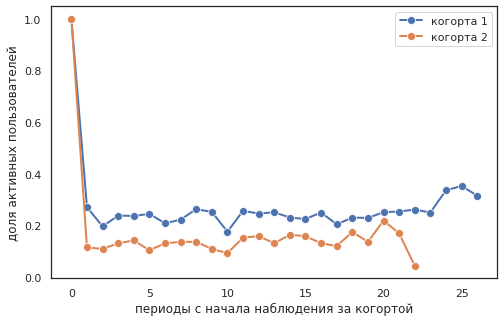

In [55]:
retention_c1 =  data_c1.groupby('delta')['client_id'].apply(lambda x: len(set(x)))
retention_c2 =  data_c2.groupby('delta')['client_id'].apply(lambda x: len(set(x)))


sns.lineplot(x = retention_c1.index, y = retention_c1.values/max(retention_c1.values),
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = retention_c2.index, y = retention_c2.values/max(retention_c2.values),
             lw = 2, marker="o", markersize = 8)

plt.xlabel('периоды с начала наблюдения за когортой')
plt.ylabel('доля активных пользователей')

plt.legend(labels=["когорта 1","когорта 2"])
plt.show()


Мы видим, что когорта первых двух недель 1го месяца (напомним - cohort_size был 14 дней, а две когорты брались с 60 дневной разницей) обладает сильно боолеее высоким retention, чем когоорта пользователей первых двух недель 3-го месяца



Можно напримеер сравнить эти группы по другим признакам - например, по числу покупок на человека.

In [0]:
purch_c1 =  data_c1.groupby('delta').apply(lambda x: len(x['Description'])/x['client_id'].nunique())
purch_c2 =  data_c2.groupby('delta').apply(lambda x: len(x['Description'])/x['client_id'].nunique())

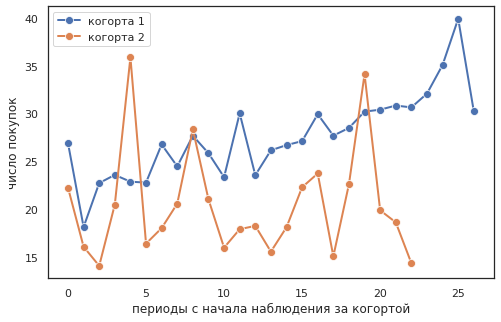

In [58]:
sns.lineplot(x = purch_c1.index, y = purch_c1.values,
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = purch_c2.index, y = purch_c2.values,
             lw = 2, marker="o", markersize = 8)

plt.xlabel('периоды с начала наблюдения за когортой')
plt.ylabel('число покупок')

plt.legend(labels=["когорта 1","когорта 2"])
plt.show()

Видно, что когорта 1 - делала боольше покупок на человека.


Или например можно построить средний чек для каждой из когорт:

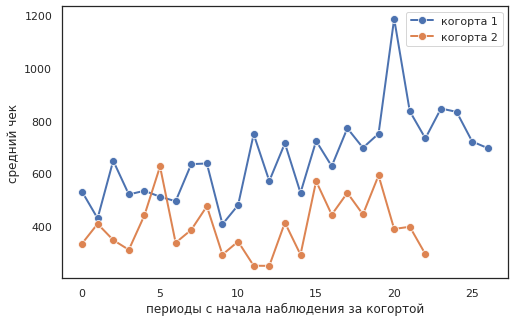

In [59]:
conv_c1 =  data_c1.groupby('delta').apply(lambda x: (x['UnitPrice']*x['Quantity']).sum()/x['client_id'].nunique())
conv_c2 =  data_c2.groupby('delta').apply(lambda x: (x['UnitPrice']*x['Quantity']).sum()/x['client_id'].nunique())

sns.lineplot(x = conv_c1.index, y = conv_c1.values,
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = conv_c2.index, y = conv_c2.values,
             lw = 2, marker="o", markersize = 8)

plt.xlabel('периоды с начала наблюдения за когортой')
plt.ylabel('средний чек')

plt.legend(labels=["когорта 1","когорта 2"])
plt.show()

Видно, что когорта 1 тратила больше денег за заказ, чем когорта 2

## 2. Выделение сегментов внутри когорт


Важно  помнить, что в общем случае, когорты можно выделять произвольным образом в зависимости от анализа. 

В примерее выше мы сделали  выделение когорт на основе acquisition time.

Давайте рассмотрим теперь другой способ выделения когорт, например по географическому признаку. Для этого опять изолируем пользователей пришедших за определенный  промежуток времени (например тоже за первые две недели наблюдения) и разобьем их на две когорты - пользователи из UK и не UK

In [0]:
#найдем для пользоваателей их даты присоединения:
g_data = data.groupby('client_id')['timestamp'].first().to_frame()
#колонка delta - день присоединения с начала наблюдения:
g_data['delta'] = (g_data['timestamp'] - data['timestamp'].min()).apply(lambda x: x.days)


In [0]:
data['acquisition_day'] = data['client_id'].map(g_data['delta'].to_dict())

разделим  когорты на сегменты по географии:

In [0]:
cohort_size =  14

cohort_1_users = data.loc[(data['acquisition_day']<=cohort_size) &
                          (data['Country']=='United Kingdom')]['client_id'].unique()

cohort_2_users = data.loc[(data['acquisition_day']<=cohort_size) &
                          (data['Country']!='United Kingdom')]['client_id'].unique()

#полные логи событий для каждой из когорт:
data_c1 = data[data['client_id'].isin(cohort_1_users)].copy()
data_c2 = data[data['client_id'].isin(cohort_2_users)].copy()

Далее можем провести сравнителньый анализ аналогичный проделанному выше по выделенным  когортам:

In [0]:
data_c1['delta'] = (data_c1['timestamp'] - data_c1['timestamp'].min())\
                    .apply(lambda x: np.floor(x.days / cohort_size))


data_c2['delta'] = (data_c2['timestamp'] - data_c2['timestamp'].min())\
                    .apply(lambda x: np.floor(x.days / cohort_size))


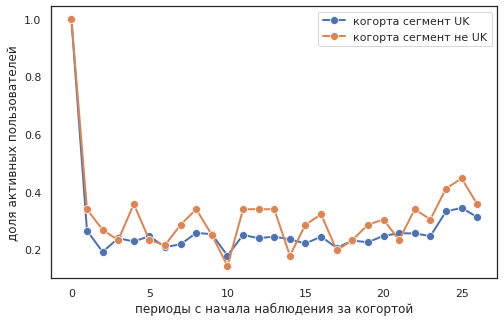

In [67]:
retention_c1 =  data_c1.groupby('delta')['client_id'].apply(lambda x: len(set(x)))
retention_c2 =  data_c2.groupby('delta')['client_id'].apply(lambda x: len(set(x)))


sns.lineplot(x = retention_c1.index, y = retention_c1.values/max(retention_c1.values),
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = retention_c2.index, y = retention_c2.values/max(retention_c2.values),
             lw = 2, marker="o", markersize = 8)

plt.xlabel('периоды с начала наблюдения за когортой')
plt.ylabel('доля активных пользователей')

plt.legend(labels=["когорта сегмент UK","когорта сегмент не UK"])
plt.show()


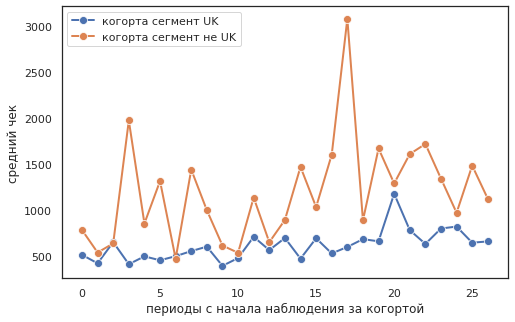

In [66]:
conv_c1 =  data_c1.groupby('delta').apply(lambda x: (x['UnitPrice']*x['Quantity']).sum()/x['client_id'].nunique())
conv_c2 =  data_c2.groupby('delta').apply(lambda x: (x['UnitPrice']*x['Quantity']).sum()/x['client_id'].nunique())

sns.lineplot(x = conv_c1.index, y = conv_c1.values,
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = conv_c2.index, y = conv_c2.values,
             lw = 2, marker="o", markersize = 8)

plt.xlabel('периоды с начала наблюдения за когортой')
plt.ylabel('средний чек')

plt.legend(labels=["когорта сегмент UK","когорта сегмент не UK"])
plt.show()

Видно, что пользователи за пределами UK покупали в целом покупки на больший средний чек чем в UK


## 3.  Когортная матрица retention для многих групп:

В  примерах выше мы сравнивали между собой поведение двух групп. В аналитике часто применяется способ визуализации retention через когортную матрицу, который позволяет наглядно оценить как меняется retention (доля активных пользователей) для различных когорт разбитых по времени присоединения.

Для этого различные когорты пользоваателей выделяются в строки, а столбцы означают номер недели с момента начала наблюдения за когортой. Таким образом поолучается диагональная матрица, так  как период наблюдения за более раннеей когортой пользователей будет дольше, чем за когортой недавно присоединившихся пользователей.



In [0]:
data['delta'] = (data['timestamp']-data['timestamp'].min()).apply(lambda x: x.days)

In [0]:
#за интервал возьмем 1 месяц:
cohort_size = 30

data['acquisition_period'] = data['acquisition_day'].apply(lambda  x: np.floor(x / cohort_size))
data['activity_week'] = data['delta'].apply(lambda  x: np.floor(x / cohort_size))
data['lifetime_period'] =  data['activity_week'] - data['acquisition_period']

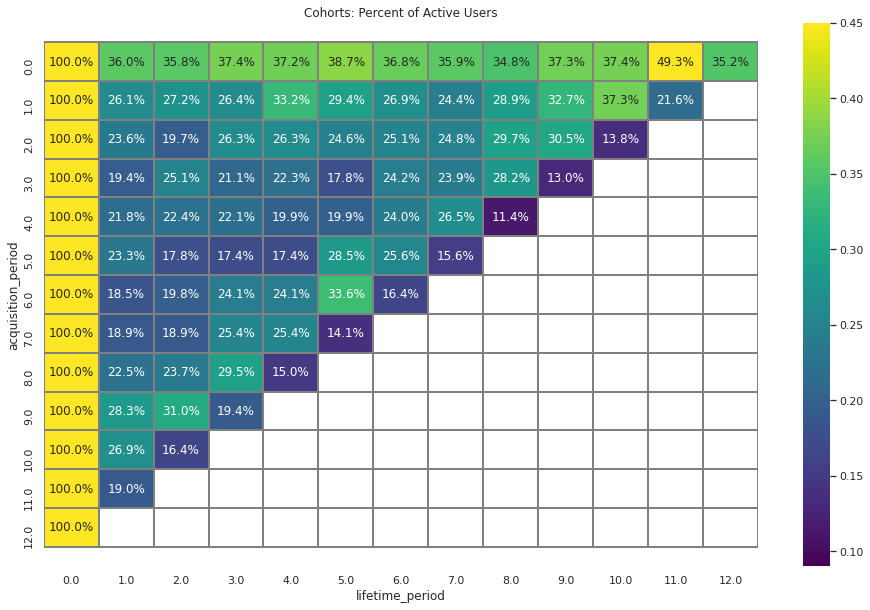

In [76]:
cohorts = data.groupby(['acquisition_period','lifetime_period']).agg({'client_id':'nunique'}).reset_index()

inital_users_count = cohorts[cohorts['lifetime_period'] == 0][['acquisition_period','client_id']]
inital_users_count = inital_users_count.rename(columns={'client_id':'cohort_users'})


cohorts = cohorts.merge(inital_users_count,on='acquisition_period')
cohorts['metric'] = cohorts['client_id']/cohorts['cohort_users']

cohort_metric_pivot = cohorts.pivot_table(index='acquisition_period',
                                      columns='lifetime_period'
                                      ,values='metric',
                                      aggfunc='sum')

sns.set(style='white', context='notebook', rc={'figure.figsize':(16,10)})

plt.title('Cohorts: Percent of Active Users')
sns.heatmap(cohort_metric_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='viridis',
            vmin=0.09, vmax=0.45,)

b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

plt.show();

Строки в данной матрице, выделяющиеся более высокими значениями от остальных строк - когорты пользователей с более высокой активностью. Например, на примере выше вторая когорта оказалась явно с более высокой активностью. Из этих данных мождно сделать например, что маркетинговые кампании привлекающие пользователей в этот период были лучше таргетированы и приводиили более целевую аудиторию

# 4. Выделение сегментов в когортной матрице

Когортная матрица для пользователей в UK:

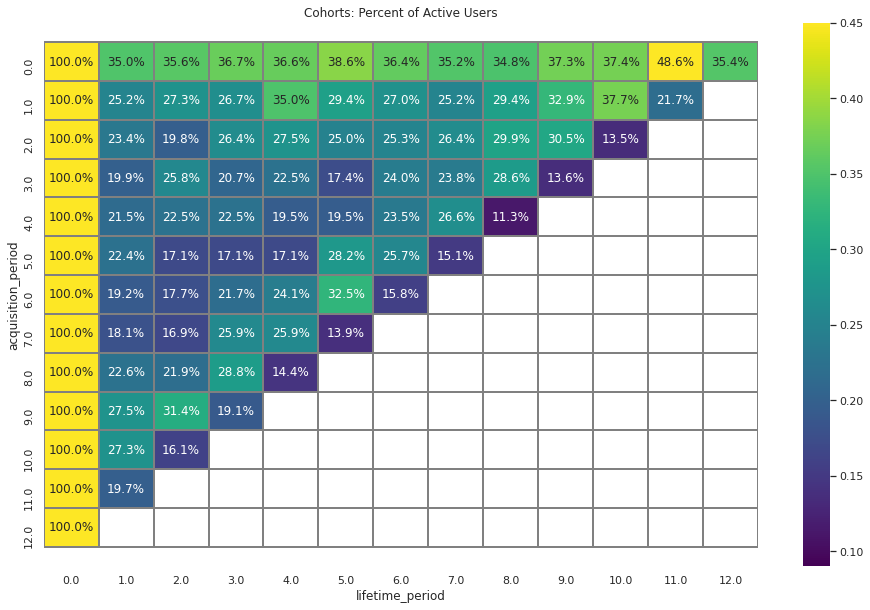

In [78]:
cohorts = data[data['Country']=='United Kingdom'].groupby(['acquisition_period','lifetime_period']).agg({'client_id':'nunique'}).reset_index()

inital_users_count = cohorts[cohorts['lifetime_period'] == 0][['acquisition_period','client_id']]
inital_users_count = inital_users_count.rename(columns={'client_id':'cohort_users'})


cohorts = cohorts.merge(inital_users_count,on='acquisition_period')
cohorts['metric'] = cohorts['client_id']/cohorts['cohort_users']

cohort_metric_pivot = cohorts.pivot_table(index='acquisition_period',
                                      columns='lifetime_period'
                                      ,values='metric',
                                      aggfunc='sum')

sns.set(style='white', context='notebook', rc={'figure.figsize':(16,10)})

plt.title('Cohorts: Percent of Active Users')
sns.heatmap(cohort_metric_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='viridis',
            vmin=0.09, vmax=0.45,)

b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

plt.show();

Когортная матрица для пользователей за пределами UK:

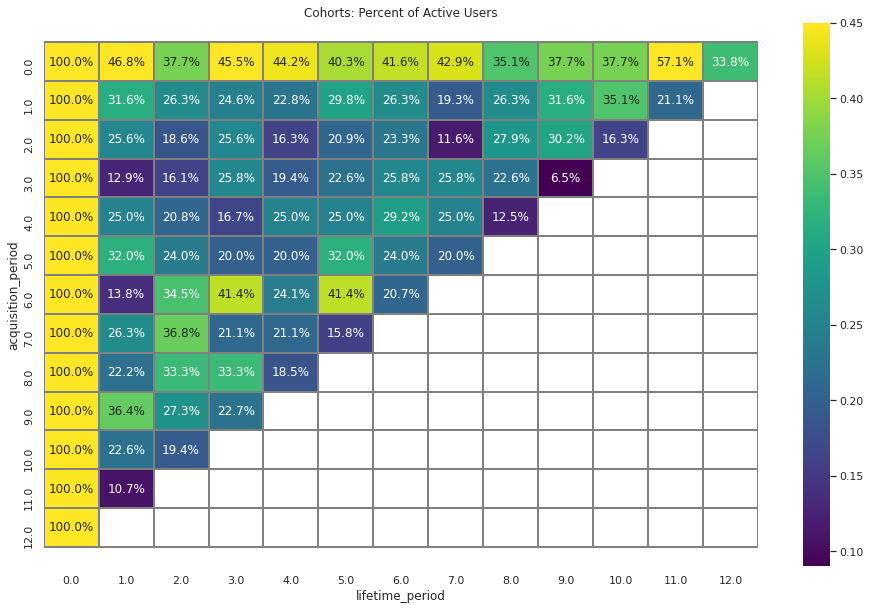

In [79]:
cohorts = data[data['Country']!='United Kingdom'].groupby(['acquisition_period','lifetime_period']).agg({'client_id':'nunique'}).reset_index()

inital_users_count = cohorts[cohorts['lifetime_period'] == 0][['acquisition_period','client_id']]
inital_users_count = inital_users_count.rename(columns={'client_id':'cohort_users'})


cohorts = cohorts.merge(inital_users_count,on='acquisition_period')
cohorts['metric'] = cohorts['client_id']/cohorts['cohort_users']

cohort_metric_pivot = cohorts.pivot_table(index='acquisition_period',
                                      columns='lifetime_period'
                                      ,values='metric',
                                      aggfunc='sum')

sns.set(style='white', context='notebook', rc={'figure.figsize':(16,10)})

plt.title('Cohorts: Percent of Active Users')
sns.heatmap(cohort_metric_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='viridis',
            vmin=0.09, vmax=0.45,)

b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

plt.show();